In [ ]:
# Emile Mathieu CIFAR-CNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 169M/169M [00:03<00:00, 54.5MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [ ]:
# We need to initializae a trainer loader to iterate over our dataset to get std and mean
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False)

In [ ]:
img_shape = train_dataset[0][0].shape
print(img_shape)

torch.Size([3, 32, 32])


In [ ]:
# Compute mean and std over the entire dataset
mean = 0.0
std = 0.0
for images, _ in train_loader:
    # images shape: (batch_size, 3, 32, 32)
    batch_samples = images.size(0)
    # Compute mean per batch
    mean += images.mean([0, 2, 3]) * batch_samples
    std += images.std([0, 2, 3]) * batch_samples

num_samples = len(train_loader.dataset)
mean /= num_samples
std /= num_samples

print("Calculated Mean:", mean)
print("Calculated Std:", std)


Calculated Mean: tensor([0.5071, 0.4865, 0.4409])
Calculated Std: tensor([0.2669, 0.2560, 0.2756])


In [ ]:
# Mean and std are acquired so we define a transform that enables normalization
#Add normalization transforms
train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=False,
    transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)])
)

test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=False,
    transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)])
)

#Our loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
#I am building a simple model based on a Lab I did on CNN's.
class AdvancedLabModel(nn.Module):
    def __init__(self, num_classes=100):
        super(AdvancedLabModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Added batch normalization to stabilize learning process:
        # https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)


        self.fc = nn.Linear(128 * 4 * 4, num_classes)

        # Added dropout:
        #https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
        self.dropout = nn.Dropout(0.5)

    # This setup has Convolution -> ReLU -> MaxPool
    def forward(self, x):
        x = F.relu(self.conv1(x))
        # Added also batch normalization.
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
         # Added also batch normalization.
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        # Added also batch normalization,
        x = self.bn3(x)
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 128 * 4 * 4)

        # Added dropout for better results:
        # https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
criterion = nn.CrossEntropyLoss()
model = AdvancedLabModel().to(torch.device('cuda'))
use_gpu = torch.device('cuda')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def train(model, train_loader, optimizer, criterion, use_gpu):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move data to gpu
        images, labels = images.to(use_gpu), labels.to(use_gpu)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and parameter update
        loss.backward()
        optimizer.step()

        # Update metrics
        running_loss, correct, total = metrics(loss, outputs, labels, images, running_loss, correct, total)

    # Compute final training loss and accuracy
    train_loss = running_loss / total
    train_acc = correct / total
    return train_loss, train_acc

def test(model, test_loader, criterion, use_gpu):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(use_gpu), labels.to(use_gpu)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()*images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss/total
    test_acc = correct/total
    return test_loss, test_acc

In [ ]:
num_epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, use_gpu)
    test_loss, test_acc = test(model, test_loader, criterion, use_gpu)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%\n")

Epoch 1/10
Train Loss: 3.6249 | Train Acc: 19.26%
Test Loss: 2.7828 | Test Acc: 31.03%

Epoch 2/10
Train Loss: 2.7150 | Train Acc: 32.82%
Test Loss: 2.3598 | Test Acc: 40.08%

Epoch 3/10
Train Loss: 2.3925 | Train Acc: 38.86%
Test Loss: 2.2043 | Test Acc: 43.12%

Epoch 4/10
Train Loss: 2.2037 | Train Acc: 43.24%
Test Loss: 2.1172 | Test Acc: 45.11%

Epoch 5/10
Train Loss: 2.0870 | Train Acc: 45.46%
Test Loss: 2.0070 | Test Acc: 47.48%

Epoch 6/10
Train Loss: 1.9951 | Train Acc: 47.84%
Test Loss: 1.9353 | Test Acc: 49.68%

Epoch 7/10
Train Loss: 1.9109 | Train Acc: 49.48%
Test Loss: 1.9087 | Test Acc: 49.99%

Epoch 8/10
Train Loss: 1.8496 | Train Acc: 50.53%
Test Loss: 1.8577 | Test Acc: 51.38%

Epoch 9/10
Train Loss: 1.7961 | Train Acc: 52.15%
Test Loss: 1.8511 | Test Acc: 51.57%

Epoch 10/10
Train Loss: 1.7473 | Train Acc: 53.29%
Test Loss: 1.7937 | Test Acc: 52.57%



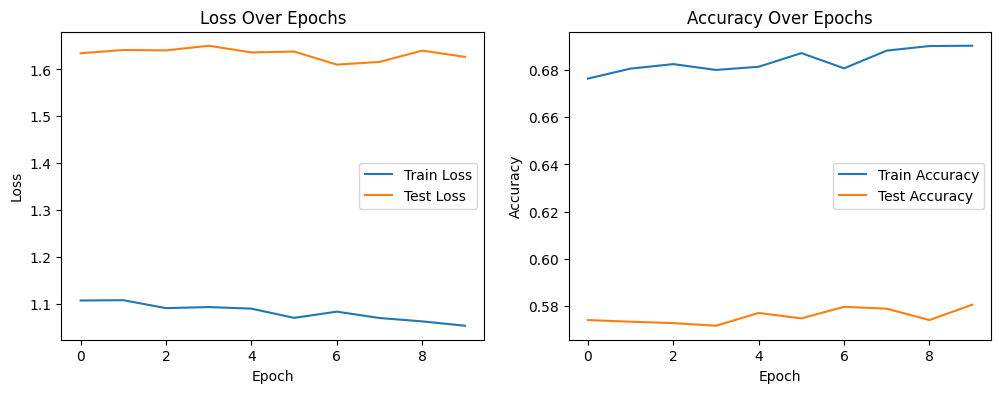

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()